# Práctica 4 - FastSLAM y Planeamiento de Trayectoria

**Profesor**: Prof. Dr. Ignacio Mas

**Fecha límite de entrega**: 24/11/2024, 23:59hs

---

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

## 1. Implementación de algoritmo FASTSLAM

En este ejercicio se implementará el algoritmo FASTSLAM basado en landmarks. Se asume que los landmarks son identificables por lo que el problema de asociación de datos está resuelto. El punto de partida es la clase `FastSLAM` del archivo `fastslam.py` del módulo `probotics`. Dicha clase contine la siguiente estructura:
```Python
class FastSLAM:
    
    def __init__(
        self, N_particles, N_landmarks, odometry_noise_params, measurement_noise, use_neff=False, seed=None
    ):
        # Constructor de la clase que implementa FastSLAM
        # ...

    def prediction_step(self, odometry):
        # Implementación del paso de predicción
        for particle in self.particles:
            particle.apply_movement(odometry['r1'], odometry['t'], odometry['r2']) 

    def correction_step(self, sensor):
        # Implementación del paso de corrección
        # ...
        
    def resampling_step(self):
        # Implementación del paso de sampleo
        # ...

    def update(self, odometry, sensor):
        # Actualización del filtro
        self.prediction_step(odometry) # predicción
        self.correction_step(sensor) # corrección
        self.resampling_step() # remuestreo
```

Al igual que en el filtro de partículas, cada actualización del algoritmo se hace con el método `update`, el cual contiene un paso de predicción, uno de corrección y uno de remuestreo.

### 1.1. Paso de corrección FASTSLAM

Implementar el paso de corrección en la función correction `correction_step(...)`. Asumir que el ruido de medición está caracterizado por la matriz diagonal cuadrada de $2\times 2$ $Q_t$:
$$
\begin{equation}
Q_t = 
\begin{bmatrix} 
0.1 & 0.0 \\
0.0 & 0.1
\end{bmatrix}
\end{equation}
$$

In [23]:
fs = FastSLAM(3, 3, [0.005, 0.01, 0.005], 0.1, False, 1234)

# Dummy measurement
measurement = {
    "odom": {"r1": 0.100692392654, "t": 0.100072845247, "r2": 0.000171392857486},
    "sensor": {"id": [1,2], "range": [1.89645381418, 3.85367751107], "bearing": [0.374031885671, 1.51951017943]}
}

# Prediction step
fs.prediction_step(measurement["odom"])

# Correction step
fs.correction_step(measurement["sensor"])

# Test correction step
assert np.isclose(np.vstack([p.sensor.landmarks.loc[1,"mu"] for p in fs.particles]), np.array([
    [1.76551   , 0.90484449],
    [1.77709773, 0.89456762],
    [1.77459723, 0.88233502]
])).all()
assert np.isclose(np.stack([p.sensor.landmarks.loc[1,"sigma"] for p in fs.particles],axis=0), np.array([
    [[ 0.15785143, -0.10804883],
     [-0.10804883,  0.30180228]],
    [[ 0.15644075, -0.10709571],
     [-0.10709571,  0.30321296]],
    [[ 0.15504399, -0.10612509],
     [-0.10612509,  0.30460972]]
])).all()

print("Correction step test passed!")       

Correction step test passed!


Una vez implementado, visualizar la implementación del algoritmo con los datos de odometría y del sensor.

<IPython.core.display.Javascript object>


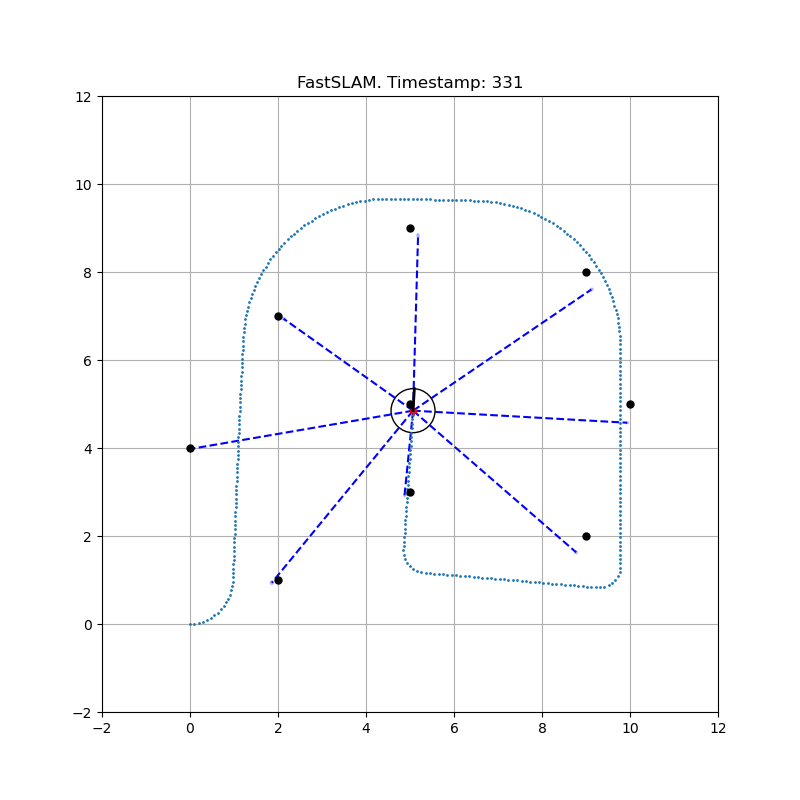

In [62]:
from probotics import DeterministicLandmarkIdentificator, FastSLAM
from probotics.src.utils import read_sensor_data, plot_landmarks_with_ellipsoids


def visualize_fastslam(N, sensor_data, world_data,  odometry_noise_params, measurement_noise, seed=None):

    # Leemos los landmarks verdaderos
    landmarks = DeterministicLandmarkIdentificator.from_file(world_data, 0.).landmarks

    # Inicializamos el filtro de partículas
    fs = FastSLAM(N, len(landmarks), odometry_noise_params, measurement_noise, use_neff=False, seed=seed)
    poses = fs.get_particles_poses()
    best_particle = fs.get_best_particle()

    # Leemos los datos del sensor
    sensor_data = read_sensor_data(sensor_data)
    
    # Inicializamos el plot
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    plt.ion()
    fig.show()

    # Actualización del filtro de partículas y gráfico
    for t in range(len(sensor_data)):
        
        # Graficamos
        ax.cla()
        ax.set_xlim(-2, 12)
        ax.set_ylim(-2, 12)
        ax.set_aspect('equal')
        ax.grid(True)
        ax.set_title("FastSLAM. Timestamp: " + str(t))
        plot_landmarks_with_ellipsoids(ax, best_particle.robot.current_pose, best_particle.sensor.landmarks)
        ax.plot(poses[:,0], poses[:,1], 'r.')
        ax.plot(best_particle.robot.pose_history[:,0],best_particle.robot.pose_history[:,1], "o", ms=1)
        ax.plot(landmarks['x'], landmarks['y'], 'ko', markersize=5)
        best_particle.robot.plot(ax, color='k')
        fig.canvas.draw()
        
        # Actualizamos el filtro de partículas
        fs.update(sensor_data[t]['odom'], sensor_data[t]['sensor'])
        
        # Obtenemos las poses de las partículas y la posición promedio
        poses = fs.get_particles_poses()
        best_particle = fs.get_best_particle()
        
    # Último plot
    ax.cla()
    ax.set_xlim(-2, 12)
    ax.set_ylim(-2, 12)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title("FastSLAM. Timestamp: " + str(len(sensor_data)))
    plot_landmarks_with_ellipsoids(ax, best_particle.robot.current_pose, best_particle.sensor.landmarks)
    ax.plot(poses[:,0], poses[:,1], 'r.')
    ax.plot(best_particle.robot.pose_history[:,0],best_particle.robot.pose_history[:,1], "o", ms=1)
    ax.plot(landmarks['x'], landmarks['y'], 'ko', markersize=5)
    best_particle.robot.plot(ax, color='k')
    fig.canvas.draw()
    
N = 100
sensor_data = "../data/slam/sensor_data.dat"
world_data = "../data/slam/world.dat"
odometry_noise_params = [0.005, 0.01, 0.005]
measurement_noise = 0.1
seed = 1234
visualize_fastslam(N, sensor_data, world_data, odometry_noise_params, measurement_noise, seed)

## 2. Planeamiento de caminos

Los algoritmos de búsqueda en grafos como Dijkstra o A* pueden ser usados para planear caminos en grafos desde un lugar de inicio hasta un objetivo. Si las celdas de un mapa de grilla se representan como nodos conectados con sus celdas vecinas, estos algoritmos pueden aplicarse directamente para realizar planeamiento para robots. Para este ejercicio, consideramos las 8 celdas vecinas de una celda $\langle x, y \rangle$, que se definen como las celdas adyacentes a $\langle x, y \rangle$ horizontalmente, verticalmente y en diagonal. 

La clase `Planning` del archivo `base.py` del módulo `probotics` es la clase base para implementar el planeamiento de un camino. La misma tiene la siguiente estructura:
```Python

class Planning:

    def __init__(self, map_data, start=np.array([0, 0]), goal=np.array([0, 0]), threshold=0.5):
        # Constructor de la clase
        # ...
        
    def plan(self):
        # Método que implementa el algoritmo de planeamiento
        # ...
        return summary
    
    def get_neighbors(self, cell):
        # Método que define cuáles son los vecinos de una celda
    
    def cell_is_occupied(self, cell):
        # Se fija si una celda está ocupada

    def get_edge_cost(self, parent, child):
        # Define el costo entre de un arco entre dos nodos
    
    def get_heuristic(self, cell):
        # Define una heurística para mejorar la eficiencia de búsqueda
        raise NotImplementedError
```

El método `plan` ejecuta el planeamiento y devuelve un resumen del algoritmo que incluye datos como el historial y los nodos visitados.

### 2.1. Algoritmo de Dijkstra

El algoritmo de Dijkstra se usa para calcular caminos de costo mínimo dentro de un grafo. Durante la búsqueda, siempre se busca el nodo del grafo con el menor costo desde el punto de inicio y se agregan los nodos vecinos al grafo de búsqueda.

1. Sea $M(x, y)$ un mapa de grilla de ocupación. Durante la búsqueda, las celdas se conectan con sus celdas vecinas para construir el grafo de búsqueda. Completar la función `get_neighbors` de la clase `Planning` que define los vecinos de una celda. La función toma como entrada las coordenadas de una celda y devuelve un vector de $n \times 2$ con las coordenadas de sus celdas vecinas, teniendo en cuenta los límites del mapa.

In [29]:
from probotics import Planning

map_data = np.zeros((10,10))
plan = Planning(map_data, start=np.array([0, 0]), goal=np.array([0, 0]), threshold=0.5)
neighbors = plan.get_neighbors((3,5))

# Test neighbors function
assert np.array_equal(neighbors, np.array([
    [2, 4], [2, 5], [2, 6], [3, 4], [3, 6],  [4, 4], [4, 5], [4, 6]
]))
print("Neighbors test passed!")

Neighbors test passed!


2. Implementar la función `get_edge_cost` para los costos de un arco entre nodos que permita planear caminos de mínima longitud y libre de colisiones. Considerar la celda como un obstáculo si su probabilidad de ocupación supera cierto umbral. ¿Qué umbral se debería elegir?

In [33]:
parent = np.array([0,1])
child = np.array([0,2])
assert plan.get_edge_cost(parent, child) >= 0
print("get_edge_cost method runned succesfully!")

get_edge_cost method runned succesfully!


3. Incluir información de ocupación en la función de costo que permita que el algoritmo elija celdas con baja probabilidad de ocupación sobre celdas con mayor probabilidad de ocupación.

Visualizar el algoritmo de Dijkstra con el siguiente código.

<IPython.core.display.Javascript object>


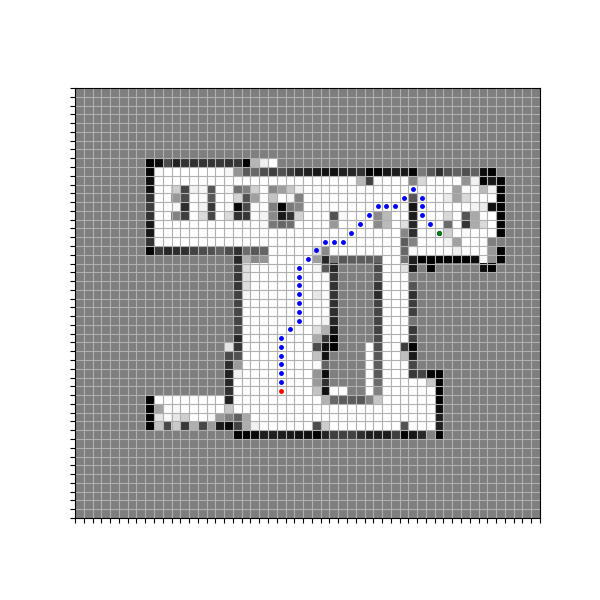

In [61]:
import time
from probotics import Dijkstra, AStar

def read_map(map_path):
    map_data = pd.read_csv(map_path, header=None, index_col=None, sep=' ', skiprows=5)
    map_data = map_data.values[:, 1:]
    return map_data

def visualize_planning(map_path, start, goal, method, factor, threshold):
    map_data = read_map(map_path)

    # Initialize planning
    if method == "dijkstra":
        planning = Dijkstra(map_data, start=start, goal=goal, threshold=threshold)
    elif method == "a_star":
        planning = AStar(map_data, start=start, goal=goal, threshold=threshold, factor=factor)

    # Plan
    summary = planning.plan()

    # Plot history
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    plt.ion()
    fig.show()
    for parent in summary["history"]:
        ax.cla()
        ax.imshow(map_data, cmap='gray_r')
        ax.set_aspect('equal')
        ax.set_xticks(np.arange(0, map_data.shape[1]+1, 1)-0.5)
        ax.set_xticklabels([])
        ax.set_yticks(np.arange(0, map_data.shape[0]+1, 1)-0.5)
        ax.set_yticklabels([])
        ax.grid(which='both')
        ax.plot(start[1], start[0], 'r.', markersize=5)
        ax.plot(goal[1], goal[0], 'g.', markersize=5)
        if np.all(parent != start):
            ax.plot(parent[1], parent[0], 'y.', markersize=5)
        fig.canvas.draw()
        time.sleep(0.01)
    
    for cell in summary["path_cells"]:
        ax.plot(cell[1], cell[0], 'b.', markersize=5)
    ax.plot(goal[1], goal[0], 'g.', markersize=5)
    fig.canvas.draw()

map_path = "../data/planning/map.mat"
start = np.array([34, 23])
goal = np.array([16,41])
threshold = 0.2
factor = 1
visualize_planning(map_path, start, goal, "dijkstra", factor, threshold)

## 2.2. Algoritmo $A^*$

El algoritmo $A^*$ utiliza una heurística para realizar una búsqueda informada que resulta ser más eficiente que el algoritmo de Dijkstra.

1. ¿Qué propiedades debe tener dicha heurística para asegurar que $A^*$ es óptimo?

La heurística debe ser admisible y consistente para asegurar que $A^*$ es óptimo. 

2. Definir una heurística para planeamiento de robots móviles en 2-D. Completar la función `get_heuristics` de la clase `AStar`. La función toma como entrada las coordenadas de una celda y del objetivo, y devuelve el costo estimado hasta el objetivo.

Se eligió una heurística como la suma de dos términos:
$$
h = 10 \cdot \mathrm{ProbOcupacion}(x, y) + \mathrm{DistanciaAlOptimo}(x, y)
$$
El término $\mathrm{ProbOcupacion}(x, y)$ representa la probabilidad de ocupación de la celda y el término $\mathrm{DistanciaAlOptimo}(x, y)$ representa la distancia euclidiana entre la celda y el objetivo.

3. ¿Qué pasa si se aumenta la heurística usando $h_2$, siendo $h_2$ un múltiplo de la heurística $h$ definida en el punto anterior. Analizar el comportamiento con diferentes factores: $h_2 = a\,h,\;\; a \in \{1, 2, 5, 10\}$

Visualizing for factor = 1


<IPython.core.display.Javascript object>


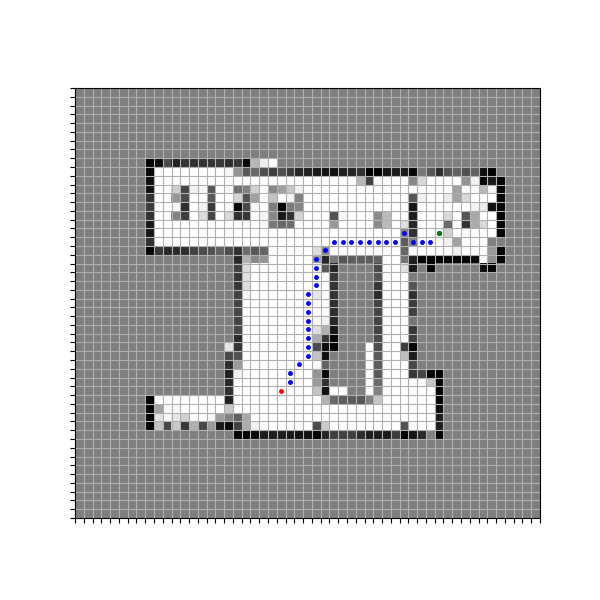

Visualizing for factor = 2


<IPython.core.display.Javascript object>


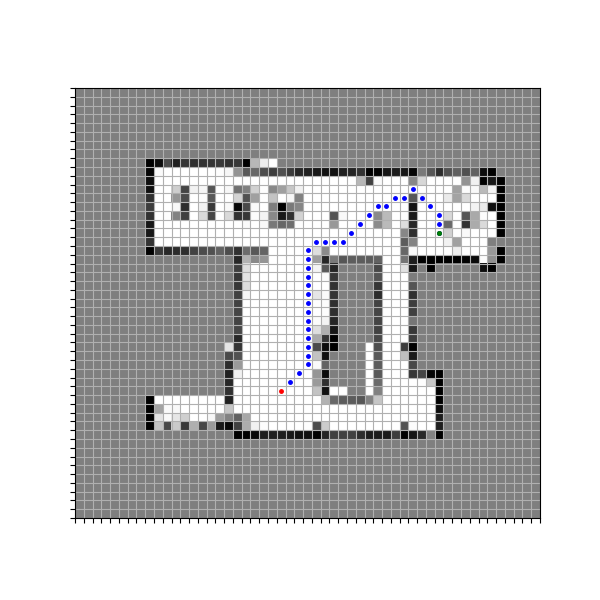

Visualizing for factor = 5


<IPython.core.display.Javascript object>


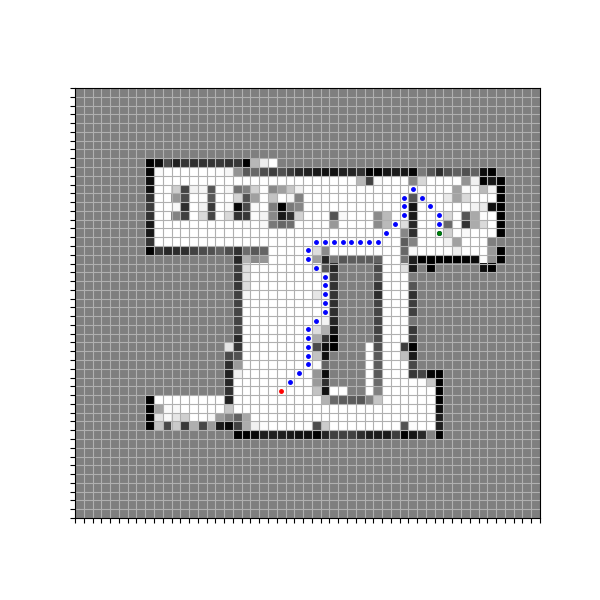

Visualizing for factor = 10


<IPython.core.display.Javascript object>


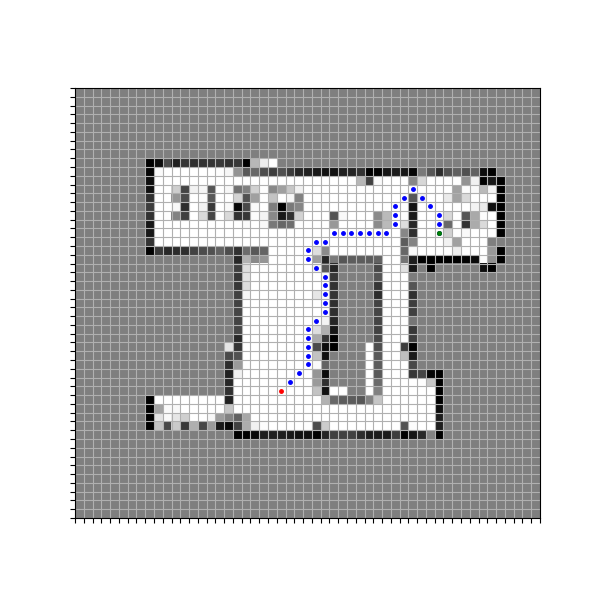

In [60]:
map_path = "../data/planning/map.mat"
start = np.array([34, 23])
goal = np.array([16,41])
threshold = 0.5

for factor in [1, 2, 5, 10]:
    print(f"Visualizing for factor = {factor}")
    visualize_planning(map_path, start, goal, "a_star", factor, threshold)